# Load data and library

In [1]:
# import basic library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import sys
import ast
import pickle

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, RandomizedSearchCV

from lightgbm import LGBMClassifier

import shap

In [2]:
# helper function to get the feature preprocessing pipeline
def get_feature_pipeline(numerical, nominal, ordinal, algorithm):
    preprocess_numerical = FunctionTransformer(lambda x: x[numerical], validate = False)
    preprocess_nominal = FunctionTransformer(lambda x: x[nominal], validate = False)
    preprocess_ordinal = FunctionTransformer(lambda x: x[ordinal], validate = False)
    if algorithm == 'Logistic Regression':
        pl_numerical = Pipeline([('selector_numerical', preprocess_numerical),
                                 ('imputer', SimpleImputer(strategy = 'median')),
                                 ('scaler', MinMaxScaler())])                    
        pl_nominal = Pipeline([('selector_nominal', preprocess_nominal),
                               ('imputer', SimpleImputer(strategy = 'most_frequent')),
                               ('encoder', OneHotEncoder())])
        pl_ordinal = Pipeline([('selector_ordinal', preprocess_ordinal),
                               ('imputer', SimpleImputer(strategy = 'most_frequent')),
                               ('encoder', OrdinalEncoder())])
        feature_pipeline = FeatureUnion([('pipeline_numerical', pl_numerical),
                                         ('pipeline_nominal', pl_nominal),
                                         ('pipeline_ordinal', pl_ordinal)])
        return feature_pipeline
    
    elif algorithm == 'GBM':
        pl_numerical = Pipeline([('selector_numerical', preprocess_numerical)])
        pl_nominal = Pipeline([('selector_nominal', preprocess_nominal),
                               ('encoder', OneHotEncoder())])
        pl_ordinal = Pipeline([('selector_ordinal', preprocess_ordinal),
                               ('encoder', OrdinalEncoder())])
        feature_pipeline = FeatureUnion([('pipeline_numerical', pl_numerical),
                                         ('pipeline_nominal', pl_nominal),
                                         ('pipeline_ordinal', pl_ordinal)])
        return feature_pipeline
    else:
        print('algorithm argument is wrong. Try "Logistic Regression" or "GBM"!')
        return None

# get the feature importance from LGBM
def feature_importance(model, name, input_features = None, plot = True, max_num_features = 15, figsize = (6, 4)):
    if input_features == None:
        numerical = list(model[0].transformer_list[0][1].steps[0][1].transform(app_train).columns)
        ordinal = list(model[0].transformer_list[2][1].steps[1][1].feature_names_in_)
        nominal = list(model[0].transformer_list[1][1].steps[1][1].get_feature_names_out())
        all_columns = numerical + ordinal + nominal
        df = pd.DataFrame({'Feature':all_columns, 'Number of Split':model[1].feature_importances_}).sort_values('Number of Split', ascending = True).set_index('Feature')
    else:
        df = pd.DataFrame({'Feature':input_features, 'Number of Split':model.feature_importances_}).sort_values('Number of Split', ascending = True).set_index('Feature')
    if plot == True:
        fig, ax = plt.subplots(figsize = figsize)
        df.tail(max_num_features).plot(kind = 'barh', ax = ax)
        ax.set_title('Feature Importance LGBM ({})'.format(name))
        plt.show()
    return df

In [3]:
# helper function to create ROC curve
from sklearn.metrics import roc_curve
def plot_ROC_curve(model_to_plot):
    fig, ax = plt.subplots(figsize = (8, 5))
    fpr_roc = dict()
    tpr_roc = dict()
    for name, model in model_to_plot.items():
        # generate ROC curve values
        y_pred_prob = model.predict_proba(X_train)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
        fpr_roc[name] = fpr
        tpr_roc[name] = tpr
    # plot ROC curve
    for name, model in model_to_plot.items():
        ax.plot(fpr_roc[name], tpr_roc[name], label = name)
    ax.plot([0, 1], [0, 1], 'k--')
    # plt.autoscale(enable = True, axis = 'x', tight = True)
    # plt.autoscale(enable = True, axis = 'y', tight = True)    
    ax.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate', title = 'ROC Curve')
    plt.legend()
    plt.show()
    return None

# helper function to create Precision-Recall curve
from sklearn.metrics import precision_recall_curve
def plot_PR_curve(model_to_plot):
    fig, ax = plt.subplots(figsize = (8, 5))
    precision = dict()
    recall = dict()
    for name, model in model_to_plot.items():
        # generate Precision-Recall curve values
        y_pred_prob = model.predict_proba(X_train)[:, 1]
        prec, rec, thresholds = precision_recall_curve(y_train, y_pred_prob)
        precision[name] = prec
        recall[name] = rec
    # plot Precision-Recall curve
    for name, model in model_to_plot.items():
        ax.plot(recall[name], precision[name], label = name)
    ax.plot([0, 1], [0, 0], 'k--')
    # plt.autoscale(enable = True, axis = 'x', tight = True)
    # plt.autoscale(enable = True, axis = 'y', tight = True)    
    ax.set(xlabel = 'Recall', ylabel = 'Precision', title = 'Precision-Recall Curve')
    plt.legend()
    plt.show()
    return None

In [4]:
%%time
# load the final train and test dataset
app_train = pd.read_csv('final train and test dataset/app_train_final.csv')
app_test = pd.read_csv('final train and test dataset/app_test_final.csv')

# load the column names
column_names = pd.read_csv('final train and test dataset/column_names.csv')

num_columns = ast.literal_eval(column_names[column_names['variable'] == 'num_columns']['list'].tolist()[0])
cat_columns = ast.literal_eval(column_names[column_names['variable'] == 'cat_columns']['list'].tolist()[0])
nom_columns = ast.literal_eval(column_names[column_names['variable'] == 'nom_columns']['list'].tolist()[0])
ord_columns = ast.literal_eval(column_names[column_names['variable'] == 'ord_columns']['list'].tolist()[0])
poly_columns = ast.literal_eval(column_names[column_names['variable'] == 'poly_columns']['list'].tolist()[0])
creation_columns = ast.literal_eval(column_names[column_names['variable'] == 'creation_columns']['list'].tolist()[0])
bureau_app_columns = ast.literal_eval(column_names[column_names['variable'] == 'bureau_app_columns']['list'].tolist()[0])
previous_app_columns = ast.literal_eval(column_names[column_names['variable'] == 'previous_app_columns']['list'].tolist()[0])

Wall time: 26.2 s


In [5]:
print('app_train shape:', app_train.shape)
print('app_test shape:', app_test.shape)

app_train shape: (307511, 709)
app_test shape: (48744, 708)


In [6]:
app_train['CODE_GENDER'] = pd.Categorical(app_train['CODE_GENDER'], ordered = True, categories = ['F', 'M'])
app_test['CODE_GENDER'] = pd.Categorical(app_test['CODE_GENDER'], ordered = True, categories = ['F', 'M'])

app_train['FLAG_OWN_CAR'] = pd.Categorical(app_train['FLAG_OWN_CAR'], ordered = True, categories = ['N', 'Y'])
app_test['FLAG_OWN_CAR'] = pd.Categorical(app_test['FLAG_OWN_CAR'], ordered = True, categories = ['N', 'Y'])

app_train['FLAG_OWN_REALTY'] = pd.Categorical(app_train['FLAG_OWN_REALTY'], ordered = True, categories = ['N', 'Y'])
app_test['FLAG_OWN_REALTY'] = pd.Categorical(app_test['FLAG_OWN_REALTY'], ordered = True, categories = ['N', 'Y'])

app_train['YEARS_BIRTH_SEGMENT'] = pd.Categorical(app_train['YEARS_BIRTH_SEGMENT'], ordered = True)
app_test['YEARS_BIRTH_SEGMENT'] = pd.Categorical(app_test['YEARS_BIRTH_SEGMENT'], ordered = True)

# Evaluate final model

In [7]:
%%time
# preprocessing the features

# set the feature pipeline
LGBM_features_total = get_feature_pipeline(numerical = num_columns + creation_columns + bureau_app_columns + previous_app_columns, 
                                           nominal = nom_columns, 
                                           ordinal = ord_columns, 
                                           algorithm = 'GBM')
# train data and test data
X_train = LGBM_features_total.fit_transform(app_train)
y_train = app_train[['TARGET']]
X_test = LGBM_features_total.transform(app_test)
display(X_train)
display(X_test)

# extract the features from preprocessing pipeline
num_after = LGBM_features_total.transformer_list[0][1].steps[0][1].transform(app_train).columns.tolist()
nom_after = LGBM_features_total.transformer_list[1][1].steps[1][1].get_feature_names_out().tolist()
ord_after = LGBM_features_total.transformer_list[2][1].steps[1][1].feature_names_in_.tolist()
all_columns_after = num_after + nom_after + ord_after
print('Total features after preprocessing in Pipeline:', len(all_columns_after))

<307511x793 sparse matrix of type '<class 'numpy.float64'>'
	with 132771518 stored elements in Compressed Sparse Row format>

<48744x793 sparse matrix of type '<class 'numpy.float64'>'
	with 20640285 stored elements in Compressed Sparse Row format>

Total features after preprocessing in Pipeline: 793
Wall time: 43 s


In [8]:
# load 'LGBM_total'
LGBM_total = pickle.load(open('LGBM_total.sav', 'rb'))
LGBM_total

LGBMClassifier(class_weight='balanced', objective='binary', random_state=42,
               reg_alpha=0.1, reg_lambda=0.1, subsample=0.9)

In [9]:
# load 'tuned_LGBM_1'
tuned_LGBM_1 = pickle.load(open('tuned_LGBM_1.sav', 'rb'))
tuned_LGBM_1

LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=0.8214285714285714,
               learning_rate=0.06324276084276478, max_depth=8, n_estimators=750,
               objective='binary', random_state=42,
               reg_alpha=0.42857142857142855, reg_lambda=0.2857142857142857,
               subsample=0.6428571428571428)

## ROC curve

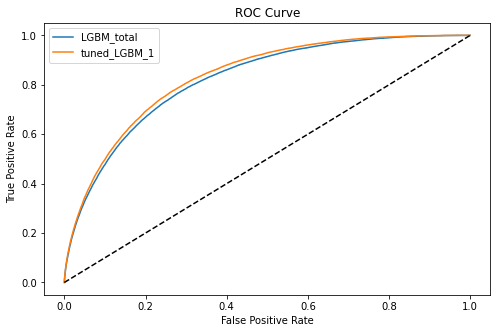

In [10]:
# plot the ROC curve
plot_ROC_curve(model_to_plot = {'LGBM_total':LGBM_total,
                                'tuned_LGBM_1':tuned_LGBM_1})

## PR curve

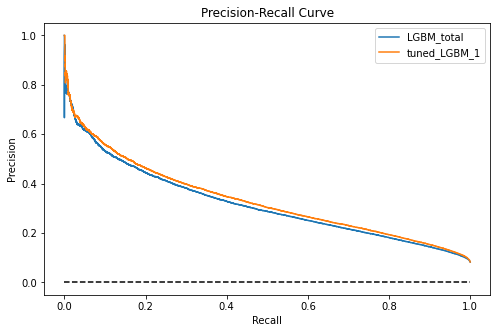

In [11]:
# plot the Precision-Recall curve
plot_PR_curve(model_to_plot = {'LGBM_total':LGBM_total,
                               'tuned_LGBM_1':tuned_LGBM_1})

## Feature importance 

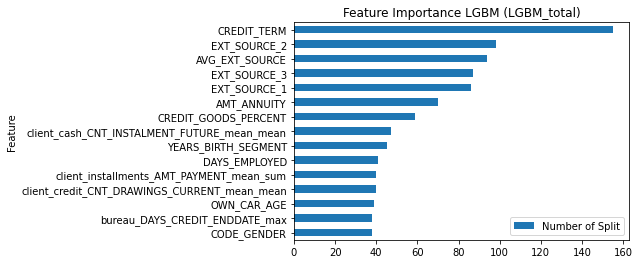

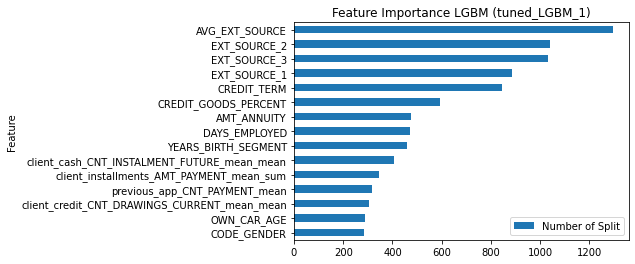

In [12]:
LGBM_total_importances = feature_importance(LGBM_total, name = 'LGBM_total',
                                            input_features = all_columns_after, 
                                            plot = True, 
                                            max_num_features = 15, figsize = (6, 4))

LGBM_total_importances = feature_importance(tuned_LGBM_1, name = 'tuned_LGBM_1',
                                            input_features = all_columns_after, 
                                            plot = True, 
                                            max_num_features = 15, figsize = (6, 4))

## SHAP values

In [33]:
input_array = X_train.toarray()
input_array.shape

(307511, 793)

In [14]:
# %%time
import shap
# compute SHAP values of each feature in input_array data
explainer = shap.Explainer(tuned_LGBM_1, 
                           input_array, 
                           feature_names = all_columns_after)

shap_values = explainer(input_array, check_additivity = False)

100%|===================| 307510/307511 [201:40<00:00]        

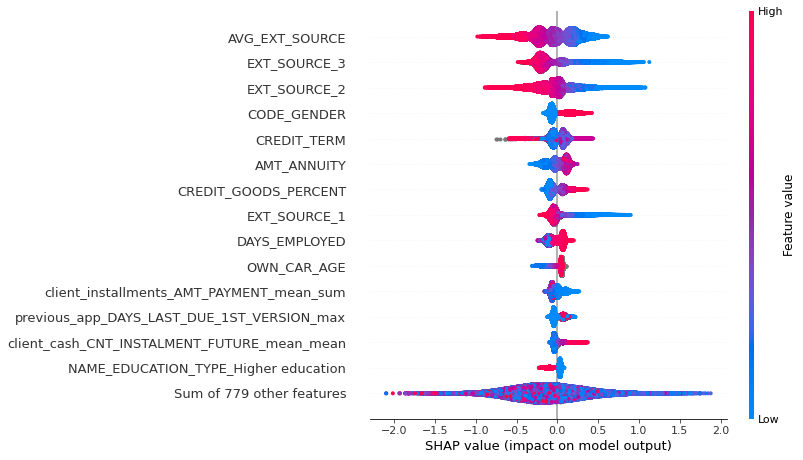

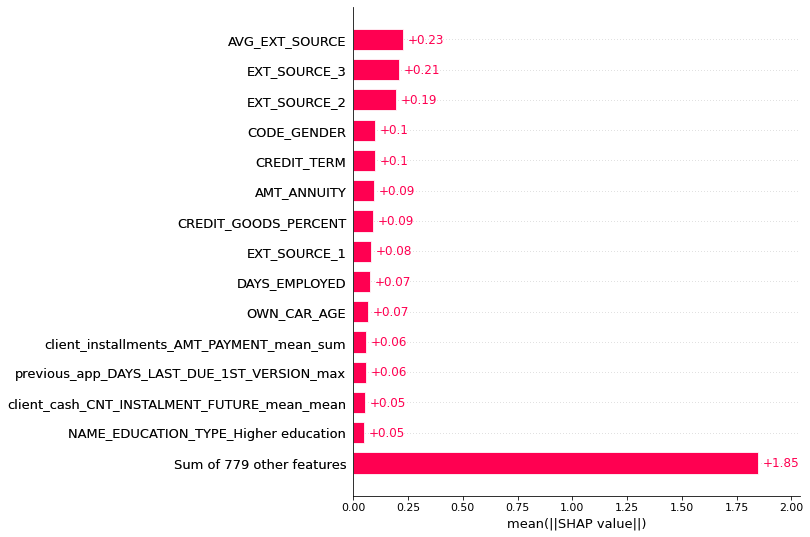

In [16]:
# plot SHAP values of each feature in X_train_preprocessed data as beeswarm plot
shap.plots.beeswarm(shap_values, max_display = 15)
                   
# plot the feature importance base on absolute SHAP values
shap.plots.bar(shap_values.abs, max_display = 15)

In [40]:
def check_memory_usage(var):
    print('%s KB'%(sys.getsizeof(var)/1000))
    return None

### Save shap_values object locally

`shap_values` size after saving locally is 3.9 GB, So I would not recommend you to save it locally. But, you must consider that to get these `shap_values` of all records in `app_train` (i.e. 307511 records), it took me 4 hours to run! So it's a worth value for me to save it to my disk.

In [59]:
%%time
import pickle
# save the shap_values to disk
filename = 'shap_values (tuned_LGBM_1).sav'
pickle.dump(shap_values, open(filename, 'wb'))

# load the shap_values from disk
loaded_object = pickle.load(open(filename, 'rb'))
print('type of "loaded_object":', type(loaded_object))
print('type of "shap_values"', type(shap_values))

type of "loaded_object": <class 'shap._explanation.Explanation'>
type of "shap_values" <class 'shap._explanation.Explanation'>
Wall time: 26.3 s


In [60]:
check_memory_usage(shap_values)

0.048 KB


In [61]:
check_memory_usage(loaded_object)

0.048 KB


### Save explainer object locally

In [56]:
%%time
import pickle
# save the shap_values to disk
filename = 'explainer (tuned_LGBM_1).sav'
pickle.dump(explainer, open(filename, 'wb'))

# load the shap_values from disk
loaded_object = pickle.load(open(filename, 'rb'))
print('type of "loaded_object":', type(loaded_object))
print('type of "explainer"', type(explainer))

type of "loaded_object": <class 'shap.explainers._tree.Tree'>
type of "explainer" <class 'shap.explainers._tree.Tree'>
Wall time: 674 ms


In [63]:
check_memory_usage(explainer)

0.048 KB


In [64]:
check_memory_usage(loaded_object)

0.048 KB
